## Link To Drive

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
%cd "/content/drive/My Drive/Research/FIRE/2020-Speech-Recognition/Model"
!ls

/content/drive/My Drive/Research/FIRE/2020-Speech-Recognition/Model
alphabet.txt  ASR_Model.ipynb  configuration.yaml


## Install Required Libraries

In [1]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=cd2486fb28c3b1fdf790f306e5f769f9db360bd1babfe8ae7ba0800ee0520f9c
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


## Encode Audio

In [2]:
import numpy as np
import python_speech_features
import librosa

conf = {"winfunc": np.hamming, "winlen": 0.025, "winstep": .01, "nfilt": 80}

def get_features(files):
    mfccs = [make_features(file) for file in files]
    X = align(mfccs)
    return X

def make_features(file_path):
    """ Use `python_speech_"features` lib to extract MFCC features from the audio file. """
    audio, fs = librosa.load(file_path, sr=16000)
    audio = (audio * 32768).astype("int16")
    feat, energy = python_speech_features.fbank(audio, samplerate=fs, **conf)
    features = np.log(feat)
    return features

def align(arrays, default=0):
    """ Pad arrays along time dimensions. Return the single array (batch_size, time, features). """
    max_array = max(arrays, key=len)
    X = np.full(shape=[len(arrays), *max_array.shape], fill_value=default, dtype=np.float64)
    for index, array in enumerate(arrays):
        time_dim, features_dim = array.shape
        X[index, :time_dim] = array
    return X

In [3]:
X = get_features(["StarWars60.wav"])
X.shape

(1, 5999, 80)

## Create Model

In [5]:
from typing import List
from keras import Model
import tensorflow
#from keras.initializers import np
from tensorflow import expand_dims, squeeze
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import Input, Lambda, LSTM, Bidirectional, Dense, ReLU, \
    TimeDistributed, BatchNormalization, Dropout, ZeroPadding2D, Conv2D, Reshape

In [6]:
from tensorflow.config import list_physical_devices

model_dir = "models/"
gpus = list_physical_devices("GPU")

### Layers

In [7]:
input_dim = 80
is_gpu = len(gpus) > 0
output_dim = 36
context = 7
units = 1024
dropouts = [0.1, .1, 0]
random_state = 1

#np.random.seed(1)
tensorflow.random.set_seed(random_state)
input_tensor = Input([None, input_dim], name='X')                           # Define input tensor [time, features]
x = Lambda(expand_dims, arguments=dict(axis=-1))(input_tensor)              # Add 4th dim (channel)
x = ZeroPadding2D(padding=(context, 0))(x)                                  # Fill zeros around time dimension
receptive_field = (2*context + 1, input_dim)                                # Take into account fore/back-ward context
x = Conv2D(filters=units, kernel_size=receptive_field)(x)                   # Convolve signal in time dim
x = Lambda(squeeze, arguments=dict(axis=2))(x)                              # Squeeze into 3rd dim array
x = ReLU(max_value=20)(x)                                                   # Add non-linearity
x = Dropout(rate=dropouts[0])(x)                                            # Use dropout as regularization

x = TimeDistributed(Dense(units))(x)                                        # 2nd and 3rd FC layers do a feature
x = ReLU(max_value=20)(x)                                                   # extraction base on the context
x = Dropout(rate=dropouts[1])(x)

x = TimeDistributed(Dense(units))(x)
x = ReLU(max_value=20)(x)
x = Dropout(rate=dropouts[2])(x)

x = Bidirectional(CuDNNLSTM(units, return_sequences=True) if is_gpu else     # LSTM handle long dependencies
                    LSTM(units, return_sequences=True, ),
                    merge_mode='sum')(x)

output_tensor = TimeDistributed(Dense(output_dim, activation='softmax'))(x)  # Return at each time step prob along characters

model = Model(inputs=input_tensor, outputs=output_tensor)

### Loss Function

In [8]:
def ctc_loss(y, y_hat):
    def get_length(tensor):
        lengths = tf.reduce_sum(tf.ones_like(tensor), 1)
        return tf.reshape(tf.cast(lengths, tf.int32), [-1, 1])

    sequence_length = get_length(tf.reduce_max(y_hat, 2))
    label_length = get_length(y)
    return tf.keras.backend.ctc_batch_cost(y, y_hat, sequence_length, label_length)

loss = ctc_loss

### Optimizer

In [9]:
from keras.optimizers import Optimizer, SGD, Adam

optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

### Callbacks

In [10]:
import os
import numpy as np
import tensorflow as tf
import logging
from keras.callbacks import Callback, TensorBoard, EarlyStopping
import dill

def save(data, file_name):
    """ Save arbitrary data in the file. """
    with open(file_name, mode='wb') as file:
        dill.dump(data, file)

logger = logging.getLogger('deepspeech')


class ResultKeeper(Callback):
    """ Save evaluation result and log the processing results. """

    def __init__(self, file_path):
        super().__init__()
        self.results = []
        self.file_path = file_path

    def _set_up_new_batch(self, *_):
        """ Set up the new list for batch results."""
        self.batch = []

    on_epoch_begin = _set_up_new_batch

    def _save_batch_result(self, index, logs={}):
        """ Add next batch loss. """
        loss = logs.get('loss')
        self.batch.append(loss)
        logger.info(f'Batch ({index}): {loss:.2f}')

    on_batch_end = _save_batch_result

    def _save_epoch_results(self, epoch, logs={}):
        """ Collect all information about each epoch. """
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        self.results.append([epoch, loss, val_loss, self.batch])
        logger.info(f'Epoch ({epoch}): {loss}   {val_loss}')
        save(self.results, self.file_path)
        logger.info(f'Evaluation results saved in {self.file_path}')

    on_epoch_end = _save_epoch_results


class CustomModelCheckpoint(Callback):
    """ Save model architecture and weights for the single or multi-gpu model. """

    def __init__(self, log_dir):
        """ Create directory where the files are stored if needed """
        super().__init__()
        self.log_dir = log_dir
        self.best_result = np.inf
        self.best_weights_path = None

    def _create_log_directory(self, _):
        """ Create the directory where the checkpoints are saved. """
        if not os.path.isdir(self.log_dir):
            os.makedirs(self.log_dir)

    on_train_begin = _create_log_directory

    def _save_model_weights(self, epoch, logs={}):
        """ Save model with weights of the single-gpu template model. """
        val_loss = logs.get('val_loss')
        name = f'weights.{epoch + 1:02d}-{val_loss:.2f}.hdf5'
        file_path = os.path.join(self.log_dir, name)
        self.model.template_model.save(file_path, overwrite=True)
        if val_loss < self.best_result:
            self.best_result = val_loss
            self.best_weights_path = file_path

    on_epoch_end = _save_model_weights

    def _set_best_weights_to_model(self, history):
        """ Set best weights to the model. Checkpoint callback save the best
        weights path. """
        self.model.template_model.load_weights(self.best_weights_path)

    on_train_end = _set_best_weights_to_model


class CustomTensorBoard(TensorBoard):
    """ This callback enable to save the batch logs. Write images and grads are
    disable. The generator is required and not supported with fit_generator. """

    def __init__(self, log_dir):
        super().__init__(log_dir)
        self.processed_batches = 0

    def _save_batch_loss(self, _, logs={}):
        """ Add value to the tensorboard event """
        loss = logs.get('loss')
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = loss
        summary_value.tag = 'Loss (each batch)'
        self.writer.add_summary(summary, self.processed_batches)
        self.writer.flush()
        self.processed_batches += 1

    on_batch_end = _save_batch_loss


class CustomEarlyStopping(EarlyStopping):
    """ The callback stops training if the minimal target is not achieved. """

    def __init__(self, **kwargs):
        mini_targets = kwargs.pop('mini_targets')
        self._mini_targets = mini_targets
        super().__init__(**kwargs)

    def on_epoch_end(self, epoch, logs=None):
        """ Finish training if the `monitor` value is too high. """
        super().on_epoch_end(epoch, logs)
        current = logs.get(self.monitor)
        if epoch in self._mini_targets and current > self._mini_targets[epoch]:
            self.model.stop_training = True

In [11]:
from keras.callbacks import Callback, TerminateOnNaN, LearningRateScheduler, ReduceLROnPlateau, History

callbacks = []
callbacks.append(TerminateOnNaN())
callbacks.append(ResultKeeper("results.bin"))
callbacks.append(CustomModelCheckpoint('checkpoints'))
callbacks.append(CustomTensorBoard('tensorboard'))
callbacks.append(CustomEarlyStopping(mini_targets={5: 200, 10:100}, monitor="val_loss", patience=3))
lr_decay = lambda epoch, lr: lr / np.power(.1, epoch)
callbacks.append(LearningRateScheduler(lr_decay, verbose= 1))

### Alphabet

In [12]:
import numpy as np
import warnings
from typing import List


class Alphabet:
    """
    Read alphabet.txt, which is the list of valid characters. Alphabet has two
    special characters:
      - space: on the beginning
      - blank: default added as the last char
    This class is used to convert characters to labels and vice versa.
    """

    def __init__(self, file_path):
        self.size = 0
        self.blank_token = None
        self._label_to_str = []
        self._str_to_label = {}
        self.process_alphabet_file(file_path)

    def __contains__(self, char):
        """ Check if char is in the Alphabet. """
        return char in self._str_to_label

    def string_from_label(self, label):
        """ Convert label to string. """
        return self._label_to_str[label]

    def label_from_string(self, string):
        """ Convert string to label. """
        return self._str_to_label[string]

    def process_alphabet_file(self, file_path):
        """ Read alphabet.txt file. """
        with open(file_path) as file:
            for line in file:
                if line.startswith('#'):
                    continue
                # Char can contain more than one letter
                char = line[:-1]  # remove the line ending
                self._label_to_str.append(char)
                self._str_to_label[char] = self.size
                self.size += 1
            # Blank token is added on the end
            self.blank_token = self.size - 1

    def get_batch_labels(self, transcripts):
        """ Convert batch transcripts to labels """
        batch_labels = [[self.label_from_string(c) for c in transcript if c in self]
                        for transcript in transcripts]

        max_len = max(map(len, batch_labels))
        default_value = self.blank_token

        for labels in batch_labels:
            remainder = [default_value] * (max_len - len(labels))
            labels.extend(remainder)

        return np.array(batch_labels)

    def get_batch_transcripts(self, sequences):
        """ Convert label sequences to transcripts. The `-1` also means the blank tag """
        return [''.join(self.string_from_label(char_label) for char_label in sequence
                        if char_label not in (-1, self.blank_token))
                for sequence in sequences]

In [13]:
alphabet = Alphabet("alphabet.txt")

## Decoder

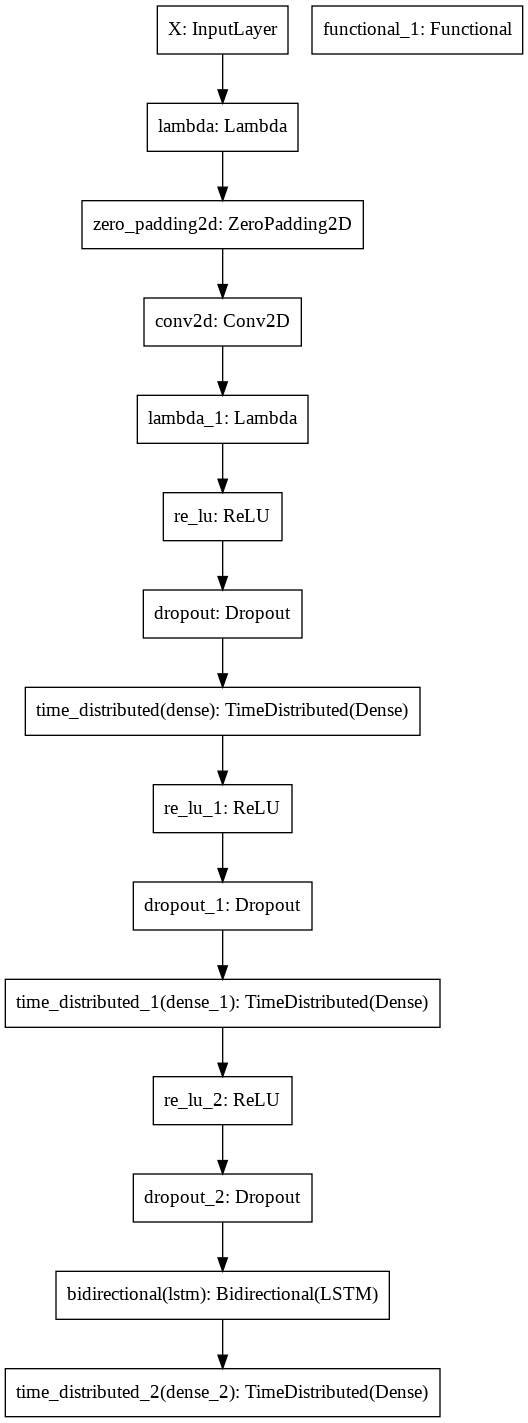

In [40]:
from keras.utils import plot_model 
plot_model(model, to_file='model.png')

In [ ]:
model.layers[-1].output

<tf.Tensor 'time_distributed_11/Reshape_1:0' shape=(None, None, 36) dtype=float32>

In [41]:
from functools import partial
from tensorflow.keras import backend as K

def get_decoder(output_tensor):
    def get_length(tensor):
        lengths = tf.reduce_sum(tf.ones_like(tensor), 1)
        return tf.cast(lengths, tf.int32)

    sequence_length = get_length(tf.reduce_max(output_tensor, 2))
    top_k_decoded, _ = K.ctc_decode(output_tensor, sequence_length, greedy=False, beam_width=64)
    print(top_k_decoded[0])
    decoder = K.function([output_tensor], [top_k_decoded[0]])
    return decoder

print(model.output)
decoder = get_decoder(model.output)
decoder = partial(ctc_decoder.batch_tensorflow_decode, alphabet=alphabet, decoder=decoder)

Tensor("time_distributed_2/Reshape_1:0", shape=(None, None, 36), dtype=float32)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Tensor("SparseToDense:0", shape=(None, None), dtype=int64)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: time_distributed_2/Reshape_1:0


ValueError: ignored

In [14]:
from keras.utils import multi_gpu_model
#print(tf.__version__)
gpus_num = len(gpus)
compiled_model = multi_gpu_model(model, gpus_num) if gpus_num > 1 else model
y = Input(name='y', shape=[None], dtype='int32')
compiled_model.compile(optimizer, loss)#, target_tensors=[y], run_eagerly=False)
compiled_model.template_model = model

## Test The Model

In [16]:
y_hat = compiled_model.predict_on_batch(X)

In [38]:
arr = [alphabet.string_from_label(l) for l in np.apply_along_axis(np.argmax, 1, y_hat[0])]
arr = [arr[0]] + [arr[i] for i in range(1,len(arr)) if arr[i] != arr[i-1] ]

In [39]:
arr

['o', 'ś', 'w', 'l', 'w', '', 'l', '', 'o', '', 'y']